Now we move on to the first nonlinear PDE, which we solve both eliminating variables and relaxing equality constraints, and then applying the Levenberg-Marquardt algorithm. First need to construct differential operators, etc. etc. 

In [29]:
import jax
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as random
from jax import vmap, grad, jacobian

jax.config.update("jax_enable_x64",True)

key = random.key(619420)
key1, key2 = random.split(key)

Burgers' equation is given by $$ \partial_t u  + u \partial_s u  - \nu \partial_s^2 u = 0, \quad (s, t) \in (-1, 1) \times (0, 1]$$ with $$u(s, 0) = \sin(\pi s), \quad u(-1, t) = u(1, t) =0 $$ and take $\nu = 0.002$. 

First define the anisotropic kernel we will be using:

In [30]:
nu = 0.02
SIGMA = jnp.array([1/20, 1/3])

def get_k(sigma):
    def k(x1, x2):
        return jnp.exp(-(1/sigma[0]**2)*(x1[0] - x2[0])**2 - (1/sigma[1]**2)*(x1[1] - x2[1])**2)
    return k

For the following, we assume $x = (s, t) \in \R^2$, and for JAX we define the argument to the differential operators as depending only on $x$, hence to differentiate kernel functions we need a wrapper that isolates either $x$ or $y$ 

In [ ]:
# L represent the functionals, missing composition with evaluation functionals. 
# fun wrt t
def L1(fun, argnums):
    def function(x, y):
        return grad(fun, argnums)(x, y)[1]
    return function

# fun wrt s
def L2(fun, argnums):
    def function(x, y):
        return grad(fun, argnums)(x, y)[0]
    return function

# partial_s^2 fun
def L3(fun, argnums):
    def function(x, y):
        return L2(L2(fun, argnums), argnums)(x, y)
    return function

def L4(fun):
    return fun

# Interior operator
def P(v1, v2, v3, v4):
    return v1 + v4*v2 - nu*v3

# Boundary operator
def B(u1, argnums = None):
    return u1

operators = {"L1": L1, "L2":L2, "L3":L3, "L4": L4, "L5": B}

def get_P_ker(kernel, argnums):
    def curlyP(x1, x2):
        return P(L1(kernel, argnums)(x1, x2), L2(kernel, argnums)(x1, x2), L3(kernel, argnums)(x1, x2), L4(kernel)(x1, x2))
    return curlyP
    


# For a univariate function $u(x)$, we may simply kernelize $u$ by considering $k(x, y) = u(x)$.
#  Can be done with lambda functions, such that this is solved with one line of code. 
# argnums = 0 because 1 would be wrt y, but y is not used. SANITY CHECK: argnums=1 should always return 0.0. 
def get_P_fun(fun):
    return lambda x: get_P_ker(lambda x, y: fun(x), argnums=0)(x, x)

In [ ]:

kernel = get_k(SIGMA)
curlyP = get_P_ker(kernel, argnums=0)
bicurlyP = get_P_ker(curlyP, argnums=1)

L1_K = L1(kernel, argnums=0)
L2_K = L2(kernel, argnums=0)
L3_K = L3(kernel, argnums=0)
L4_K = L4(kernel)

def vec_diff_combo(L_x, L_y, function, argnums = (0, 1)):
    return vmap(vmap(L_y(L_x(function, argnums = argnums[0]), argnums = argnums[1]), in_axes = (None,0)), in_axes= (0, None)) 


vec_k = vmap(vmap(kernel, in_axes = (None,0)), in_axes=(0, None))
vec_curlyP = vmap(vmap(curlyP, in_axes = (None,0)), in_axes=(0, None))
vec_bicurlyP = vmap(vmap(bicurlyP, in_axes = (None,0)), in_axes=(0, None))


first = vec_diff_combo(L1, L2, kernel)


The domain is $\Omega = [-1, 1] \times (0, 1]$

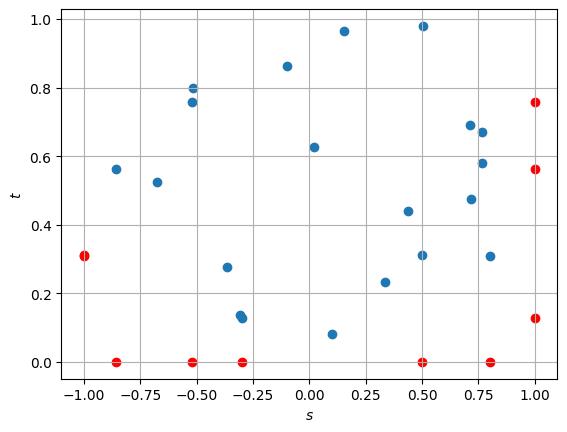

In [35]:
n_I = 20
n_B = 10
p = 1/2

X_I = jnp.concatenate((2*random.uniform(key1, shape=(n_I, 1)) - 1, random.uniform(key2, shape=(n_I, 1))), axis=1)
bd1 = jnp.concatenate((2*random.bernoulli(key1, p=p, shape=(n_B//2, 1))-1, random.uniform(key2, shape=(n_B//2, 1))), axis=1)
bd2 = jnp.concatenate((2*random.uniform(key1, shape=(n_B//2, 1)) - 1, jnp.zeros(shape=(n_B//2, 1))), axis=1)
X_B = jnp.concatenate((bd1, bd2), axis=0)

plt.scatter(X_I[:, 0], X_I[:, 1])
plt.scatter(X_B[:, 0], X_B[:, 1], color='r')
plt.ylabel('$t$')
plt.xlabel("$s$")
plt.grid()

In [ ]:
y_I = jnp.zeros(X_I.shape[0])
y_B = jnp.concatenate((jnp.zeros(shape=(n_B//2)), jnp.sin(jnp.pi*X_B[:n_B//2, 0])), axis=0)
y = jnp.concatenate((y_I, y_B))

print(first(X_I, X_B))
print()

# Wrong lel
K_II = vec_bicurlyP(X_I, X_I)
K_IB = vec_curlyP(X_I, X_B)
K_BI = K_IB.T
K_BB = vec_k(X_B, X_B)

K = jnp.block([
    [K_II, K_IB],
    [K_BI, K_BB]
])

# 4 differential operators, 1 boundary operator
Q   = 5 
Q_I = 4

N = n_I*Q_I + n_B*(Q - Q_I) # total number of functionals and point evaluations


def F(z):
    # z  dim N
    z_B = z[:n_B]
    z_I = z[n_B:].reshape((n_I, Q_I))
    
    F_vec = jnp.concatenate((P(*jnp.hsplit(z_I, Q_I)).flatten(), B(*jnp.split(z_B, Q-Q_I)).flatten()))

    return F_vec

z = jnp.ones((N, ))

print(F(z).shape)


(20, 10)
(30,)


Now gotta set up the minimization problem:

$$ \mathrm{minimize}_{z} \hspace{5pt} z^\top K_{\phi, \phi}^{-1} z \quad s.t. \quad F(z) = y$$ 

which we relax to  
$$ \mathrm{minimize}_{z} \hspace{5pt} z^\top K_{\phi, \phi}^{-1} z + \frac{1}{\beta^2} \|F(z) - y\|^2$$ 

and use the LM algorithm. 

In [50]:
def relaxed_LM(K, F ,y, beta, max_iters, x0, tol = 1e-8, reg = 1e-10, verbose = False):
    errs = []
    x = x0
    obj_val = jnp.linalg.norm(F(x) - y)

    errs.append(obj_val)
    for iter in range(max_iters):
        
        Jac = jacobian(F)(x)

        print("J", Jac.shape)

        C = Jac.T @ Jac/beta**2+ reg*jnp.eye(len(x))

        print("C", C.shape)
        print("K", K.shape)

        x = 1/beta**2 * K @ (Jac.T @ (y - F(x)) - jnp.linalg.solve(jnp.eye(len(x)) + C @ K, K @ Jac.T @ (y - F(x))))

        obj_val = jnp.linalg.norm(F(x) - y)
        errs.append(obj_val)
        if verbose: print(iter, obj_val)
        if obj_val < tol:
            return x, errs

    return x, errs

In [51]:
x, errs = relaxed_LM(K=K, F = F, y = y, x0 = jnp.zeros_like(z), beta = 0.5, max_iters = 1000, verbose=True)

J (30, 90)
C (90, 90)
K (30, 30)


TypeError: dot_general requires contracting dimensions to have the same shape, got (90,) and (30,).